In [78]:
!pip install --upgrade tdmclient
!pip install ipython
!pip install shapely
!pip install networkx


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Necessary Libraries

In [79]:
# Importing libraries
from PIL import Image
from IPython.display import Image, display
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
from shapely.geometry import Point
from itertools import combinations
import networkx as nx
from shapely.geometry import LineString


## Loading Image


[[[179 230 255]]]


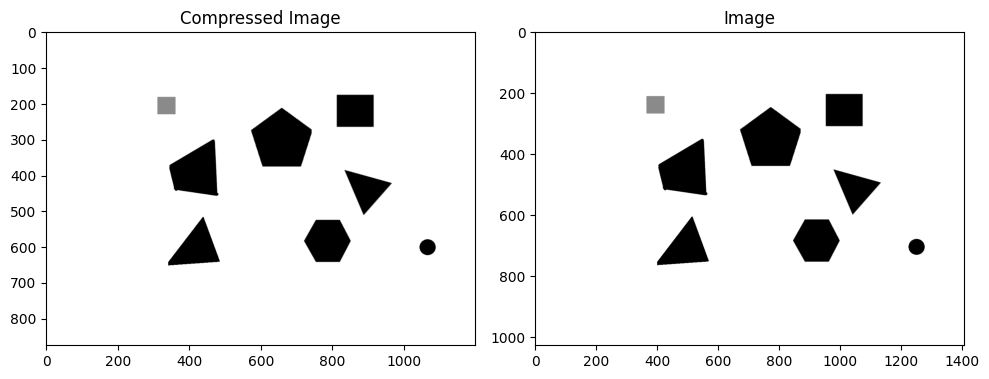

In [81]:
# Load the image
#filename = 'visibility.png'
#filename = 'visibility_bis.png'
filename = 'testImages.png'

img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Convert the image from BGR to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# converting RGB to HSV
red = np.uint8([[[35, 25, 255 ]]])
hsv_red = cv2.cvtColor(red,cv2.COLOR_BGR2HSV)
print(hsv_red)

# Define the lower and upper bounds for red color in HSV
lower_red = np.array([100, 200, 200])
upper_red = np.array([179, 255, 255])

# Create a mask for the red QR Code
red_mask = cv2.inRange(hsv, lower_red, upper_red)
# getting QR code contours
(qr_code, _) = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define the desired dimensions
new_width = 1200
new_height = 1000

# Define a kernel for dilation
kernel = np.ones((3, 3), np.uint8)

# Calculate the scaling factor to maintain aspect ratio
width, height = img.shape[1], img.shape[0]
aspect_ratio = width / height

if width / new_width > height / new_height:
    new_height = int(new_width / aspect_ratio)
else:
    new_width = int(new_height * aspect_ratio)

# Resize the image while preserving the aspect ratio
compressed_img = cv2.resize(img, (new_width, new_height))
comp_height, comp_width = compressed_img.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(compressed_img, cmap='gray')
axes[0].set_title('Compressed Image')
axes[0].axis('on')

# Display the second image (other_image)
axes[1].imshow(img, cmap='gray')
axes[1].set_title('Image')
axes[1].axis('on')

plt.tight_layout()
plt.show()

## Filtering and Enhancing Edges

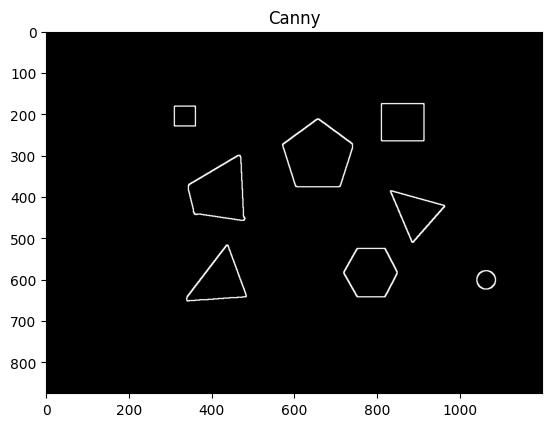

In [82]:
lower_threshold = 100
upper_threshold = 150
aperture_size = 7 # Increase if want more details

canny_img = cv2.Canny(compressed_img, lower_threshold, upper_threshold, apertureSize=aperture_size, L2gradient = True)
# Apply dilation to make edges thicker
dilated_edges = cv2.dilate(canny_img, kernel, iterations=1)

# Save the enhanced edges image
plt.imshow(dilated_edges, cmap='gray');
plt.title('Canny'); plt.axis('on');

## Scaling Contours

In [90]:
def scale_contour(cnt, scale_factor):
    # Get the bounding rectangle around the triangle
    x, y, w, h = cv2.boundingRect(cnt)

    # Calculate the center of the bounding rectangle
    center = ((x + w // 2), (y + h // 2))

    print(cnt)
    scaled_cnt = np.array([[(point[0][0] - center[0]) * scale_factor + center[0],
                            (point[0][1] - center[1]) * scale_factor + center[1]]
                           for point in cnt], dtype=np.int32)

    return scaled_cnt

## Using contour for detecting the edges of the vertices

In [91]:
# FACTOR TO INCREASE THE SIZE OF THE OBSTACLES TO ACCOUNT FOR THE THICKNESS OF THYMIO
scale_factor = 1.4

In [92]:
shape_vertices = []
shape_edges = []

# detecting the thymio location using red mask

# detecting the remaining 

(contours, _) = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

drawImg = canny_img.copy()

def detectShape(c):          #Function to determine type of polygon on basis of number of sides
       shape = 'unknown' 
       peri=cv2.arcLength(cnt,True) 
       vertices = cv2.approxPolyDP(cnt, 0.02 * peri, True)
       sides = len(vertices) 
       if (sides == 3): 
            shape='triangle' 
       elif(sides==4): 
             x,y,w,h=cv2.boundingRect(cnt)
             aspectratio=float(w)/h 
             if (aspectratio==1):
                   shape='square'
             else:
                   shape="rectangle" 
       elif(sides==5):
            shape='pentagon' 
       elif(sides==6):
            shape='hexagon' 
       elif(sides==8): 
            shape='octagon' 
       elif(sides==10): 
            shape='star'
       else:
           shape='circle' 
       return shape 

for cnt in contours:
    shape = detectShape(cnt)
    print('shape', shape)
    
    ## the approxPolyDP creates a octogon to approximate the circle
    if shape == 'octagon':
        (XGoal,YGoal), radius = cv2.minEnclosingCircle(cnt)
        (XGoal,YGoal)= (int(XGoal),int(YGoal))
        radius = int(radius)
        continue
        
    # This will be the initial position of the robot starting top left corner   
    elif shape == 'rectangle':
        # checking if the rectangle is the QR code, if it is define it as the robot
        similarity_threshold = 0.001
        similarity = cv2.matchShapes(qr_code[0], cnt, cv2.CONTOURS_MATCH_I1, 0.0)
        if similarity < similarity_threshold:
            print("Found QR Code")
            Xrob,Yrob,Wrob,Hrob=cv2.boundingRect(cnt)
            # Calculate the center of the rectangle
            Xrob_center = Xrob + Wrob // 2
            Yrob_center = Yrob + Hrob // 2
            continue
        
    # for shapes that are not the goal, increase the size to account for thickness of thymio
    cnt = scale_contour(cnt, scale_factor)
    
    vertices = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    shape = []  # Store vertices for each shape
    edges = []  # Store lines for each shape
    
    for i, vertex in enumerate(vertices):
        x, y = vertex[0]
        shape.append((x, y))

        next_index = 0 if i == len(vertices) - 1 else i + 1
        next_vertex = vertices[next_index][0]
        ## plotting vertex locations
        cv2.circle(drawImg, (x, y), 5, (255, 0, 0), -1)  
        cv2.putText(drawImg, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0,  0), 2)

        # Append edges/lines
        edges.append(((x, y), (next_vertex[0], next_vertex[1])))

    shape_vertices.append(shape)  # Append the vertices to the list
    shape_edges.append(edges)  # Append the edges to the list
         

    
print((Xrob_center,Yrob_center))
print(shape_vertices)
print(shape_edges)



shape octagon
shape hexagon
[[[752 524]]

 [[750 526]]

 [[750 527]]

 [[748 529]]

 [[748 530]]

 [[747 531]]

 [[747 532]]

 [[746 533]]

 [[746 534]]

 [[744 536]]

 [[744 537]]

 [[743 538]]

 [[743 539]]

 [[742 540]]

 [[742 541]]

 [[740 543]]

 [[740 544]]

 [[739 545]]

 [[739 546]]

 [[738 547]]

 [[738 548]]

 [[737 549]]

 [[737 550]]

 [[735 552]]

 [[735 553]]

 [[734 554]]

 [[734 555]]

 [[733 556]]

 [[733 557]]

 [[731 559]]

 [[731 560]]

 [[730 561]]

 [[730 562]]

 [[729 563]]

 [[729 564]]

 [[728 565]]

 [[728 566]]

 [[726 568]]

 [[726 569]]

 [[725 570]]

 [[725 571]]

 [[724 572]]

 [[724 573]]

 [[722 575]]

 [[722 576]]

 [[721 577]]

 [[721 578]]

 [[720 579]]

 [[720 580]]

 [[719 581]]

 [[719 586]]

 [[720 587]]

 [[720 588]]

 [[721 589]]

 [[721 590]]

 [[722 591]]

 [[722 592]]

 [[724 594]]

 [[724 595]]

 [[725 596]]

 [[725 597]]

 [[726 598]]

 [[726 599]]

 [[728 601]]

 [[728 602]]

 [[729 603]]

 [[729 604]]

 [[730 605]]

 [[730 606]]

 [[732

## Displaying the scaled Contour

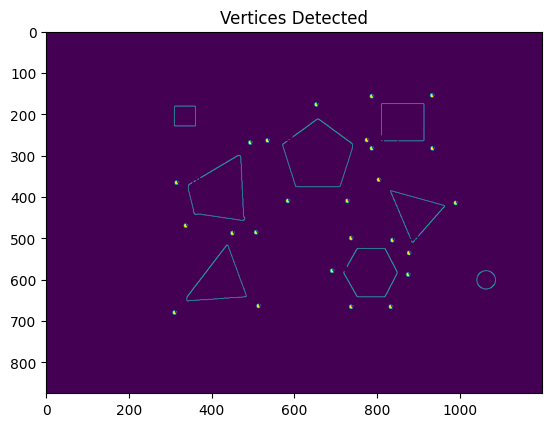

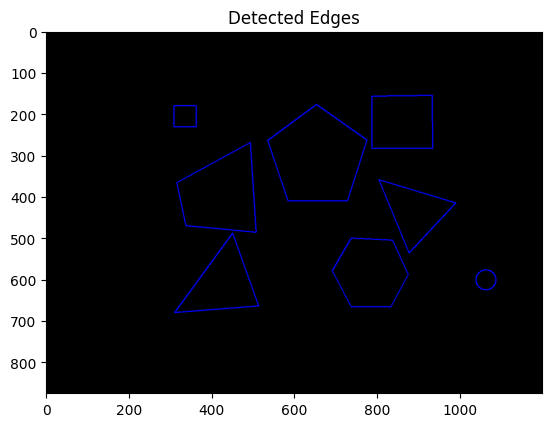

In [93]:
# Display the initial image with highlighted vertices
plt.imshow(drawImg)
plt.title('Vertices Detected')
plt.show()

# Create a blank image
blank_img = np.zeros((comp_height, comp_width, 3), np.uint8)

# Plot the lines for each shape
for edges in shape_edges:
    for edge in edges:
        cv2.line(blank_img, edge[0], edge[1], (0, 0, 255), 2)

# Draw the final position
cv2.circle(blank_img, (XGoal, YGoal), int(radius), (0, 0, 255), 2)


# Draw the robot position
cv2.rectangle(blank_img, (Xrob, Yrob), (Xrob + Wrob, Yrob + Hrob), (0, 0, 255), 2)

plt.imshow(blank_img)
plt.title('Detected Edges')
plt.axis('on')
plt.show()

## Creating optimal path to traverse through contours
Using PyVisGraph library, which creates an visiblity graph and uses Dijkstras algorithm to find the shortest path
Source: https://github.com/TaipanRex/pyvisgraph

In [94]:
!pip install pyvisgraph


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
import pyvisgraph as vg

# function returns a set of points that represent the shortest path to traverse
def getShortestPath(shape_vertices):
    polygons = []
    for shape in shape_vertices:
        polygon = []
        for point in shape:
            polygon.append(vg.Point(point[0], point[1]))
        polygons.append(polygon)

    graph = vg.VisGraph()
    graph.build(polygons)

    startPosition = vg.Point(Xrob_center,Yrob_center)
    endPosition = vg.Point(XGoal, YGoal)

    shortestPath = graph.shortest_path(startPosition, endPosition)
#     print(shortestPath)
    return shortestPath

## Drawing Optimal Path on the original image

In [96]:
edgelist = []

for i, node in enumerate(shortestPath[:-1]):
    print(shortestPath[i])
    edgelist.append((shortestPath[i], shortestPath[i + 1]))
    
print(edgelist)

NameError: name 'shortestPath' is not defined

In [ ]:
# Display the initial image with highlighted vertices
pathImage = canny_img.copy()
plt.title('Plot with vertices and optimal path')

color = (255, 255, 255)
thickness = 3
for i, edge in enumerate(edgelist):
    #print(int(edgelist[i][0].x), int(edgelist[i][0].y))
    cv2.line(pathImage, (int(edgelist[i][0].x), int(edgelist[i][0].y)), (int(edgelist[i][1].x), int(edgelist[i][1].y)), color, thickness)

plt.imshow(pathImage)
plt.show()

## Filtering out red QR Code
If we decide to use rectangle objects as obstacles, the robot QR code will need to be distinguished from that

[[[179 230 255]]]
(array([[[365, 213]],

       [[365, 269]],

       [[423, 269]],

       [[423, 213]]], dtype=int32),)


Text(0.5, 1.0, 'Result Image')

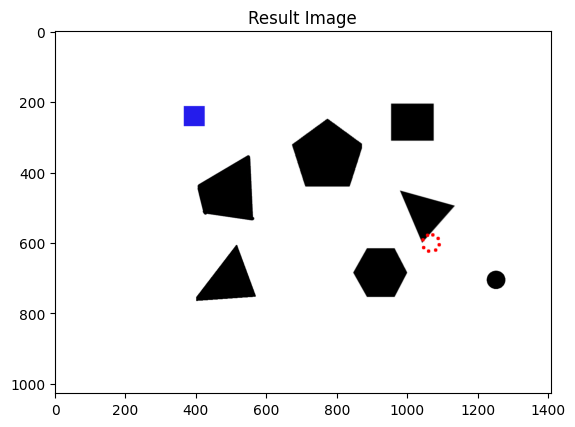

In [97]:
import cv2
import numpy as np

# Read the image
image = cv2.imread('testImages.png')

# Convert the image from BGR to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

red = np.uint8([[[35, 25, 255 ]]])
hsv_red = cv2.cvtColor(red,cv2.COLOR_BGR2HSV)
print(hsv_red)

# Define the lower and upper bounds for red color in HSV
lower_red = np.array([100, 200, 200])
upper_red = np.array([179, 255, 255])

# Create a mask for the red color
mask = cv2.inRange(hsv, lower_red, upper_red)

# Find contours in the mask
(qr_code, _) = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(qr_code)

# find contours of all shapes


# label contour
vertices = cv2.approxPolyDP(contours[0], 0.02 * cv2.arcLength(contours[0], True), True)
shape = []  # Store vertices for each shape
edges = []  # Store lines for each shape
    
    
shape_vertices = []
shape_edges = []
    
for i, vertex in enumerate(vertices):
    x, y = vertex[0]
    shape.append((x, y))

    next_index = 0 if i == len(vertices) - 1 else i + 1
    next_vertex = vertices[next_index][0]
    ## plotting vertex locations
    cv2.circle(image, (x, y), 5, (255, 0, 0), -1)  
    #cv2.putText(image, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0,  0), 2)

    # Append edges/lines
    edges.append(((x, y), (next_vertex[0], next_vertex[1])))

shape_vertices.append(shape)  # Append the vertices to the list
shape_edges.append(edges)  # Append the edges to the list

# Filter out small contours (adjust the threshold as needed)
min_contour_area = 1000
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

# Create an empty mask for the filtered contours
filtered_mask = np.zeros_like(mask)

# Draw the filtered contours on the mask
result = cv2.drawContours(filtered_mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

# Invert the mask to keep everything except the filtered region
filtered_mask_inv = cv2.bitwise_not(filtered_mask)

# # Create the result image by applying the filtered mask to the original image
# result = cv2.bitwise_and(image, image, mask=filtered_mask)

# Display the original image and the result
# plt.imshow(image)
# plt.show()
plt.imshow(image)
# plt.imshow(result)
plt.title('Result Image')




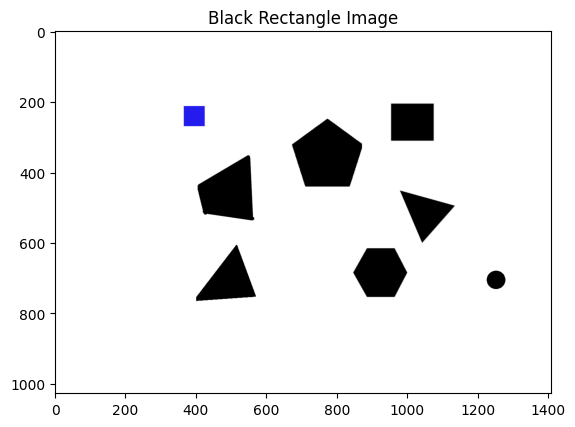

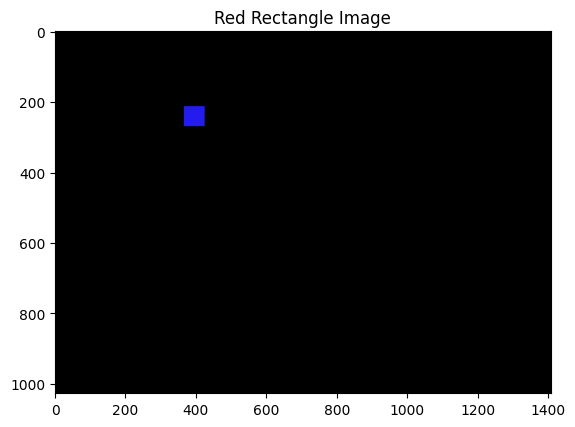

In [98]:
# Read the image
image = cv2.imread('testImages.png')

# Convert the image from BGR to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for red color in HSV
lower_red = np.array([100, 200, 200])
upper_red = np.array([179, 255, 255])

# Create a mask for the red color
red_mask = cv2.inRange(hsv, lower_red, upper_red)

# Create a mask for black color (assuming black is close to [0, 0, 0] in BGR)
lower_black = np.array([0, 0, 0])
upper_black = np.array([30, 30, 30])
black_mask = cv2.inRange(image, lower_black, upper_black)

# Combine the masks to get the red rectangle
red_rectangle = cv2.bitwise_and(image, image, mask=red_mask)

# Invert the black mask to keep everything except the black regions
black_mask_inv = cv2.bitwise_not(black_mask)
# Get the black rectangles
black_rectangles = cv2.bitwise_and(image, image, mask=black_mask_inv)

grayscale = cv2.cvtColor(black_rectangles, cv2.COLOR_BGR2GRAY)

# checking only the black contours are detected
(contours, _) = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

vertices = cv2.approxPolyDP(contours[0], 0.02 * cv2.arcLength(contours[0], True), True)
shape = []  # Store vertices for each shape
edges = []  # Store lines for each shape
    
shape_vertices = []
shape_edges = []
    
for i, vertex in enumerate(vertices):
    x, y = vertex[0]
    shape.append((x, y))

    next_index = 0 if i == len(vertices) - 1 else i + 1
    next_vertex = vertices[next_index][0]
    ## plotting vertex locations
    cv2.circle(grayscale, (x, y), 5, (255, 0, 0), -1)  
    #cv2.putText(image, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0,  0), 2)

    # Append edges/lines
    edges.append(((x, y), (next_vertex[0], next_vertex[1])))

shape_vertices.append(shape)  # Append the vertices to the list
shape_edges.append(edges)  # Append the edges to the list

# Display the original image, red rectangle, and black rectangles

plt.imshow(black_rectangles)
plt.title('Black Rectangle Image')
plt.show()
plt.imshow(red_rectangle)
plt.title('Red Rectangle Image')
plt.show()
# plt.imshow(result)


## HSV Value Test Script

In [1]:
import cv2
import sys
import numpy as np

def nothing(x):
    pass

# Create a window
cv2.namedWindow('image')
cv2.resizeWindow('image', 700, 700) 

# create trackbars for color change
cv2.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
cv2.createTrackbar('SMin','image',0,255,nothing)
cv2.createTrackbar('VMin','image',0,255,nothing)
cv2.createTrackbar('HMax','image',0,179,nothing)
cv2.createTrackbar('SMax','image',0,255,nothing)
cv2.createTrackbar('VMax','image',0,255,nothing)

# Set default value for MAX HSV trackbars.
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize to check if HSV min/max value changes
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

img = cv2.imread('testImages.png')
output = img
waitTime = 33

while(1):

    # get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin','image')
    sMin = cv2.getTrackbarPos('SMin','image')
    vMin = cv2.getTrackbarPos('VMin','image')

    hMax = cv2.getTrackbarPos('HMax','image')
    sMax = cv2.getTrackbarPos('SMax','image')
    vMax = cv2.getTrackbarPos('VMax','image')

    # Set minimum and max HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Create HSV Image and threshold into a range.
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(img,img, mask= mask)

    # Print if there is a change in HSV value
    if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display output image
    cv2.imshow('image',output)

    # Wait longer to prevent freeze for videos.
    if cv2.waitKey(waitTime) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
